In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweets-on-covid/tweetid_userid_keyword_sentiments_emotions_India.csv


In [2]:
pip install networkx matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
covid_df = pd.read_csv('/kaggle/input/tweets-on-covid/tweetid_userid_keyword_sentiments_emotions_India.csv')

In [4]:
covid_df

,tweet_ID,user_id,keywords,tweet_timestamp,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion
0,1221961336701116416,1056850669,wuhan,2020-01-28 01:01:00,0.444,0.585,0.438,0.261,0.403,-1,F
1,1221968379004772353,583952527,wuhan,2020-01-28 01:28:59,0.435,0.545,0.455,0.252,0.484,-1,F
2,1221972363010609153,3328267871,wuhan,2020-01-28 01:44:49,0.386,0.425,0.427,0.239,0.381,-1,A
3,1221974294718226432,163096597,wuhan,2020-01-28 01:52:29,0.443,0.624,0.427,0.252,0.441,-1,F
4,1221980348646490112,1220679374736744448,wuhan,2020-01-28 02:16:33,0.423,0.538,0.459,0.222,0.410,-1,F
...,...,...,...,...,...,...,...,...,...,...,...
11148975,1532330886452359169,4835227268,covid,2022-06-02 11:58:47,0.532,0.385,0.391,0.428,0.453,1,H
11148976,1532330987677306881,49877768,covid,2022-06-02 11:59:11,0.477,0.363,0.379,0.384,0.407,-1,S
11148977,1532331057789345793,3181893817,covid,2022-06-02 11:59:28,0.444,0.502,0.520,0.330,0.419,-1,A
11148978,1532331096503123968,733173343,covid,2022-06-02 11:59:37,0.574,0.452,0.374,0.385,0.420,1,H


In [5]:
import pandas as pd
import networkx as nx
from itertools import combinations
import os

# Assuming your dataset is loaded into covid_df
batch_size = 100000  # Adjust batch size based on memory capacity
combination_limit = 1000  # Limit the number of combinations per keyword (adjust based on needs)
output_dir = 'edge_batches'
os.makedirs(output_dir, exist_ok=True)

# Create the nodes dataframe
nodes_df = covid_df[['user_id']].drop_duplicates().copy()
nodes_df['Label'] = nodes_df['user_id']

# Function to process and save edges in batches
def process_edges(batch_df, batch_num):
    edges_list = []
    # Group by keywords to find users who tweeted the same keyword
    for keyword, group in batch_df.groupby('keywords'):
        unique_users = group['user_id'].unique()
        if len(unique_users) > 1:
            user_combinations = combinations(unique_users, 2)
            # Limit the number of combinations to avoid memory overload
            for idx, (user1, user2) in enumerate(user_combinations):
                if idx >= combination_limit:
                    break
                edge_data = {
                    'Source': user1,
                    'Target': user2,
                    'Weight': 1,  # You can modify this based on your criteria
                    'Keyword': keyword,
                    'Timestamp': group['tweet_timestamp'].values[0]  # Example using the first timestamp
                }
                edges_list.append(edge_data)
    
    # Save the edges batch to CSV
    edges_df = pd.DataFrame(edges_list)
    edges_file = os.path.join(output_dir, f'edges_batch_{batch_num}.csv')
    edges_df.to_csv(edges_file, index=False)
    print(f'Batch {batch_num} saved with {len(edges_list)} edges.')

# Process data in chunks
for i in range(0, len(covid_df), batch_size):
    batch_df = covid_df.iloc[i:i + batch_size]
    process_edges(batch_df, i // batch_size)

# Build the graph incrementally
G = nx.Graph()

# Load edges batch-by-batch and add to graph
for edges_file in os.listdir(output_dir):
    edges_df = pd.read_csv(os.path.join(output_dir, edges_file))
    G.add_edges_from(edges_df[['Source', 'Target']].values)
    
    # Add edge attributes
    for _, row in edges_df.iterrows():
        G[row['Source']][row['Target']].update({'Weight': row['Weight'], 'Keyword': row['Keyword'], 'Timestamp': row['Timestamp']})

# Add node attributes (Label)
for _, row in nodes_df.iterrows():
    nx.set_node_attributes(G, {row['user_id']: row['Label']}, 'label')

# Print basic graph information
print("Graph loaded. Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Batch 0 saved with 4000 edges.
Batch 1 saved with 4000 edges.
Batch 2 saved with 4000 edges.
Batch 3 saved with 4000 edges.
Batch 4 saved with 4000 edges.
Batch 5 saved with 4000 edges.
Batch 6 saved with 4000 edges.
Batch 7 saved with 4000 edges.
Batch 8 saved with 4000 edges.
Batch 9 saved with 4000 edges.
Batch 10 saved with 4000 edges.
Batch 11 saved with 3861 edges.
Batch 12 saved with 4000 edges.
Batch 13 saved with 4000 edges.
Batch 14 saved with 4000 edges.
Batch 15 saved with 4000 edges.
Batch 16 saved with 3990 edges.
Batch 17 saved with 4000 edges.
Batch 18 saved with 4000 edges.
Batch 19 saved with 4000 edges.
Batch 20 saved with 4000 edges.
Batch 21 saved with 3496 edges.
Batch 22 saved with 4000 edges.
Batch 23 saved with 4000 edges.
Batch 24 saved with 3496 edges.
Batch 25 saved with 3435 edges.
Batch 26 saved with 4000 edges.
Batch 27 saved with 3861 edges.
Batch 28 saved with 3465 edges.
Batch 29 saved with 3465 edges.
Batch 30 saved with 3703 edges.
Batch 31 saved wit

In [6]:
G

In [7]:
# Sampling a subgraph with a manageable number of nodes
sampled_nodes = list(G.nodes())[:10000]  # Adjust this number to a reasonable size
subgraph = G.subgraph(sampled_nodes)


In [8]:
import matplotlib.pyplot as plt


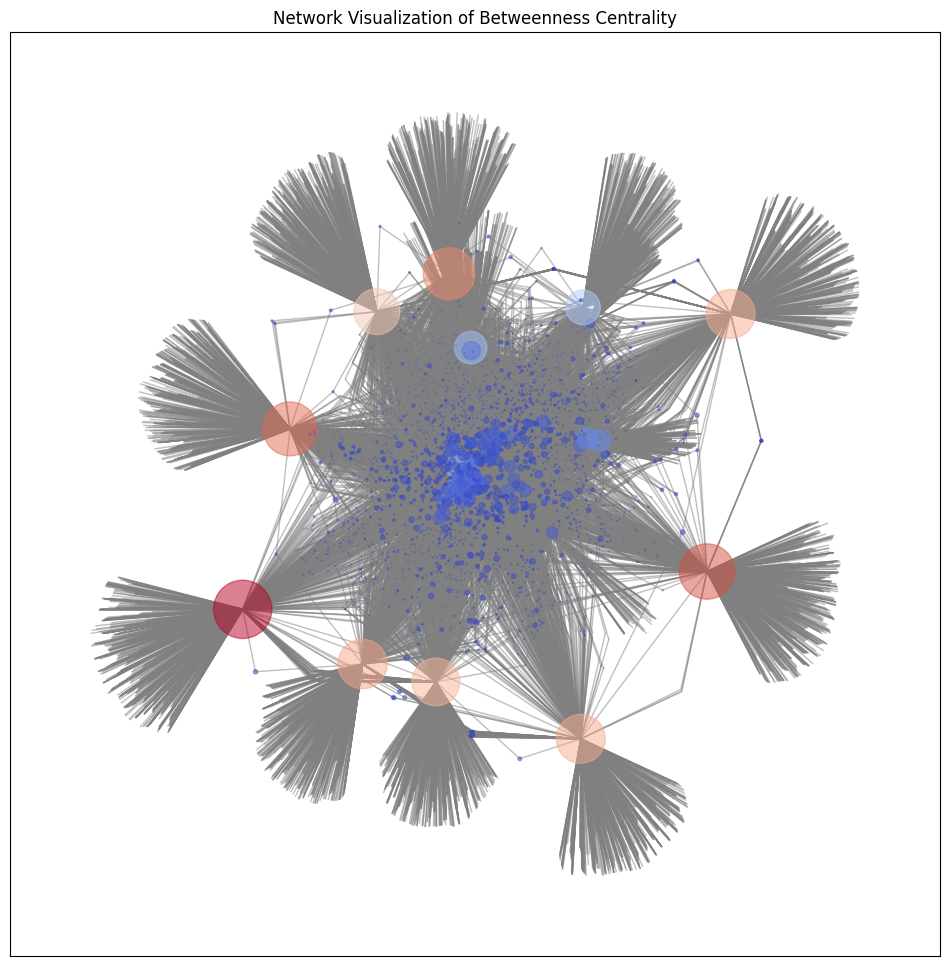

In [9]:
# Visualization of Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(subgraph, k=100, seed=42)
node_color = [betweenness_centrality.get(node, 0) for node in subgraph.nodes()]
node_size = [v * 10000 for v in betweenness_centrality.values()]

pos = nx.spring_layout(subgraph)
plt.figure(figsize=(12, 12))
nx.draw_networkx(subgraph, pos, node_color=node_color, node_size=node_size, with_labels=False, edge_color='gray', alpha=0.5, cmap=plt.cm.coolwarm)
plt.title('Network Visualization of Betweenness Centrality')
plt.show()


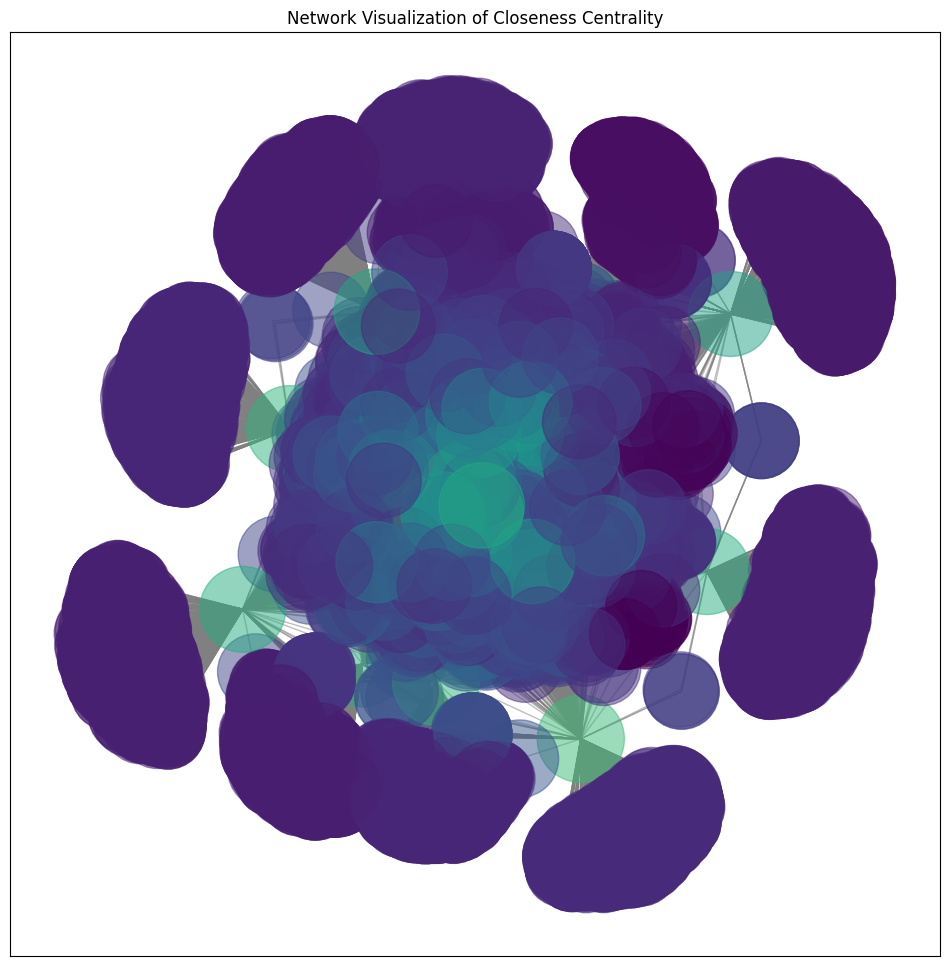

In [10]:
# Visualization of Closeness Centrality
closeness_centrality = nx.closeness_centrality(subgraph)
node_color = [closeness_centrality.get(node, 0) for node in subgraph.nodes()]
node_size = [v * 10000 for v in closeness_centrality.values()]

plt.figure(figsize=(12, 12))
nx.draw_networkx(subgraph, pos, node_color=node_color, node_size=node_size, with_labels=False, edge_color='gray', alpha=0.5, cmap=plt.cm.viridis)
plt.title('Network Visualization of Closeness Centrality')
plt.show()


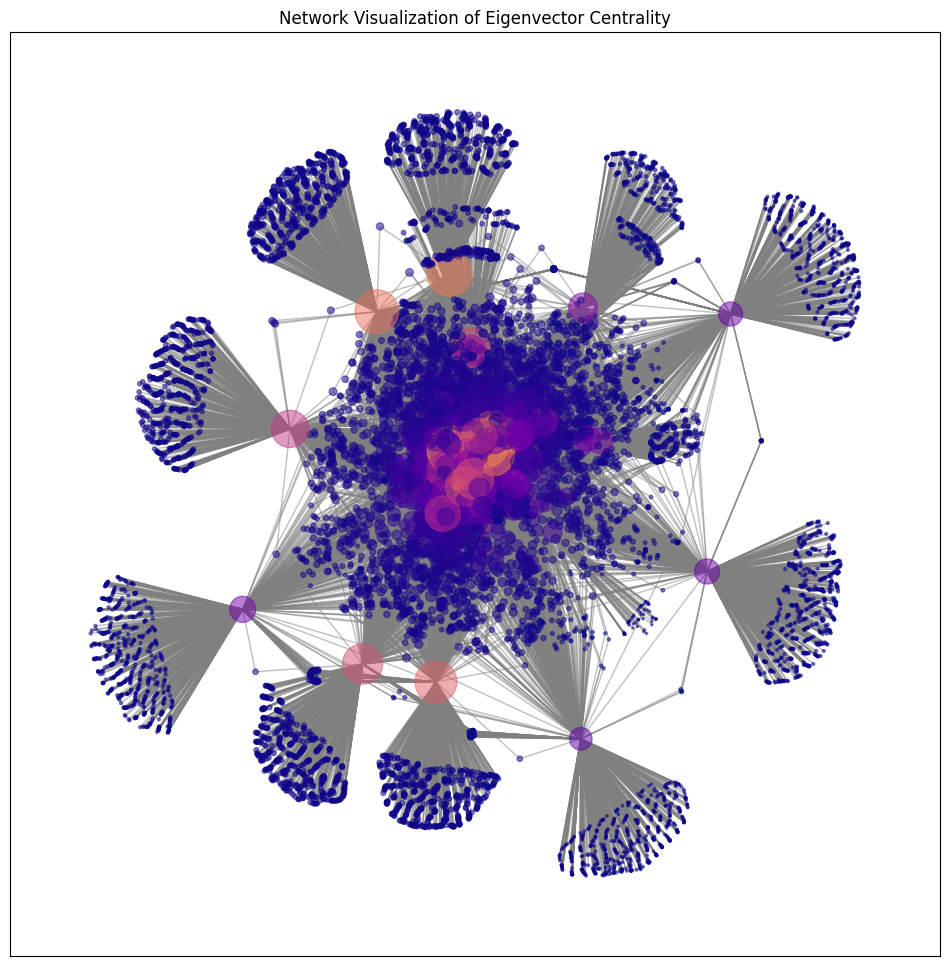

In [11]:
# Visualization of Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(subgraph, max_iter=500, tol=1e-06)
node_color = [eigenvector_centrality.get(node, 0) for node in subgraph.nodes()]
node_size = [v * 10000 for v in eigenvector_centrality.values()]

plt.figure(figsize=(12, 12))
nx.draw_networkx(subgraph, pos, node_color=node_color, node_size=node_size, with_labels=False, edge_color='gray', alpha=0.5, cmap=plt.cm.plasma)
plt.title('Network Visualization of Eigenvector Centrality')
plt.show()


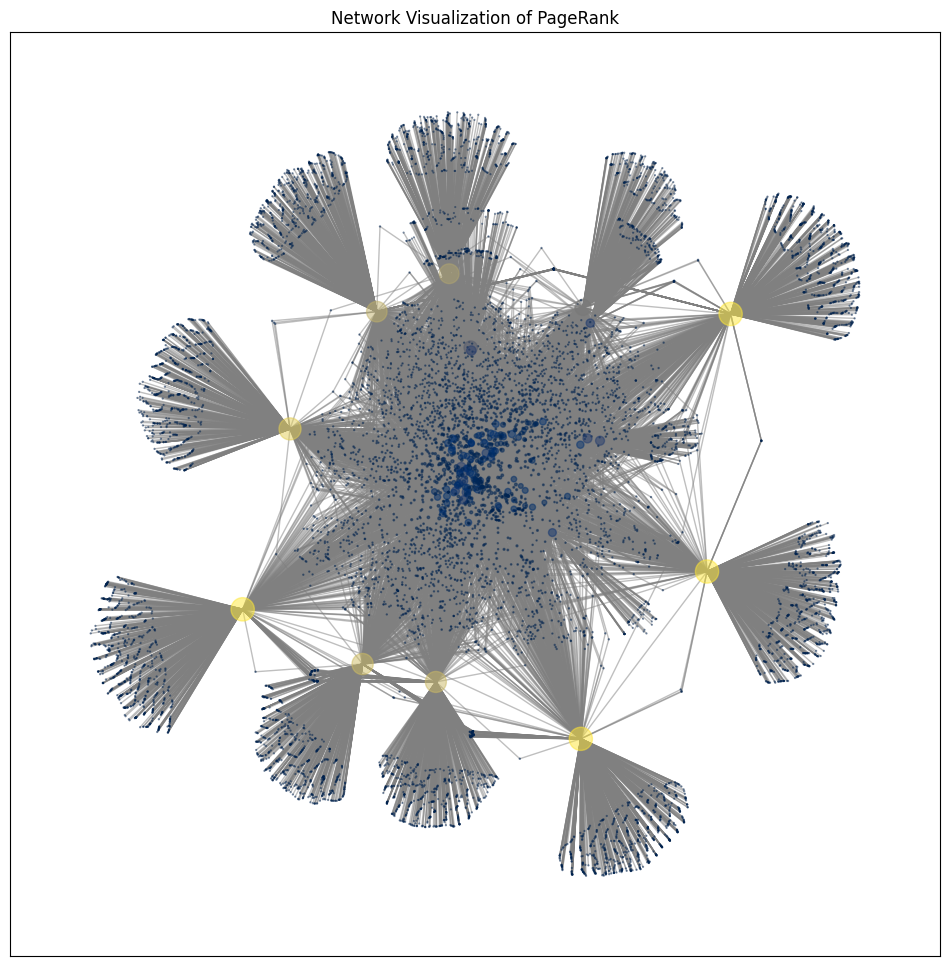

In [12]:
# Visualization of PageRank
pagerank = nx.pagerank(subgraph, max_iter=100, tol=1e-06)
node_color = [pagerank.get(node, 0) for node in subgraph.nodes()]
node_size = [v * 10000 for v in pagerank.values()]

plt.figure(figsize=(12, 12))
nx.draw_networkx(subgraph, pos, node_color=node_color, node_size=node_size, with_labels=False, edge_color='gray', alpha=0.5, cmap=plt.cm.cividis)
plt.title('Network Visualization of PageRank')
plt.show()
